In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## Data preparation

In [2]:
raw_data = pd.read_csv('datafull.csv', dtype = str)
raw_data.shape

(74576, 71)

In [3]:
#Removing any null products.
df = raw_data.drop_duplicates(subset=['itemid'], keep='first')
df = df.dropna(subset=['itemid'])
df = df.reset_index()
df.shape

(68952, 72)

In [4]:
#Checking any further null values.
df[df.columns[df.isnull().any()]].isnull().sum()

exclusive_price_info    68897
discount                44883
description                59
reference_item_id       68952
brand                   40522
shop_location              14
shop_vouchers           50374
wholesale_tier_list     68345
tier_variations           153
attributes              48792
dtype: int64

In [5]:
#Dropping these as they have excessive null values.
df = df.drop(columns=['exclusive_price_info', 'reference_item_id'])

#Fillnas to allow further manipulations.
df['discount'] = df['discount'].fillna('0') #str to maintain same dtype.
df = df.fillna('None')

In [6]:
#Splitting string into lists, delimiter was set as ';'.
df['categories'] = df['categories'].apply(lambda x : x.split(';'))
df['fe_categories'] = df['fe_categories'].apply(lambda x : x.split(';'))
df['shop_vouchers'] = df['shop_vouchers'].apply(lambda x : x.split(';'))
df['wholesale_tier_list'] = df['wholesale_tier_list'].apply(lambda x : x.split(';'))
df['models'] = df['models'].apply(lambda x : x.split(';'))
df['tier_variations'] = df['tier_variations'].apply(lambda x : x.split(';'))
df['attributes'] = df['attributes'].apply(lambda x : x.split(';'))
df['rating_count'] = df['rating_count'].apply(lambda x : x.split(';'))

#Making separate df for models and attributes to reference later on.
models = pd.DataFrame(df.models.values.tolist()).add_prefix('model')
models.insert(0, 'itemid', df.itemid)

# raw_attributes = pd.DataFrame(df.attributes.values.tolist()).add_prefix('attribute')
# raw_attributes.insert(0, 'itemid', df.itemid)

# attributes = pd.read_csv('tableau_attributes.csv')

#Spltting categories into multiple columns.
df = pd.concat([df, pd.DataFrame(df.categories.values.tolist()).add_prefix('category')], axis=1)
df = pd.concat([df, pd.DataFrame(df.fe_categories.values.tolist()).add_prefix('fe_category')], axis=1)


In [7]:
# Commented as it took 10 minutes to run. This was exported into a csv to be used again in above cell.
# Kept in here just to show how it was made.

# attributes= pd.DataFrame({
#     'itemid': [],
#     'name': [],
#     'warranty_type': [],
#     'warranty_duration': [],
#     'recommended_age': [],
#     'sports_type': [],
#     'age_group': [],
#     'gender': [],
#     'apparel_function': [],
#     'material': [],
#     'bicycle_type': [],
#     'bicycle_parts_type': [],
#     'country_origin': [],
#     'wheel_diameter': [],
#     'weight': [],
#     'number_of_speeds': []
# })

# for index, row in raw_attributes.iterrows():
#     attributes.at[index, 'itemid'] = row['itemid']
#     for i in range(18):
#         attribute_value = row[f'attribute{i}']
#         if attribute_value != 'None':
#             if 'Warranty Type' in attribute_value:
#                 attributes.at[index, 'warranty_type'] = attribute_value.removeprefix('Warranty Type - ')
#             elif 'Warranty Duration' in attribute_value:
#                 attributes.at[index, 'warranty_duration'] = attribute_value.removeprefix('Warranty Duration - ')
#             elif 'Recommended Age' in attribute_value:
#                 attributes.at[index, 'recommended_age'] = attribute_value.removeprefix('Recommended Age - ')
#             elif 'Sports Type' in attribute_value:
#                 attributes.at[index, 'sports_type'] = attribute_value.removeprefix('Sports Type - ')
#             elif 'Age Group' in attribute_value:
#                 attributes.at[index, 'age_group'] = attribute_value.removeprefix('Age Group - ')
#             elif 'Gender' in attribute_value:
#                 attributes.at[index, 'gender'] = attribute_value.removeprefix('Gender - ')
#             elif 'Apparel Function' in attribute_value:
#                 attributes.at[index, 'apparel_function'] = attribute_value.removeprefix('Apparel Function - ')
#             elif 'Material' in attribute_value:
#                 attributes.at[index, 'material'] = attribute_value.removeprefix('Material - ')
#             elif 'Bicycle Type' in attribute_value:
#                 attributes.at[index, 'bicycle_type'] = attribute_value.removeprefix('Bicycle Type - ')
#             elif 'Bicycle Parts Type' in attribute_value:
#                 attributes.at[index, 'bicycle_parts_type'] = attribute_value.removeprefix('Bicycle Parts Type - ')
#             elif 'Country of Origin' in attribute_value:
#                 attributes.at[index, 'country_origin'] = attribute_value.removeprefix('Country of Origin - ')
#             elif 'Wheel Diameter' in attribute_value:
#                 attributes.at[index, 'wheel_diameter'] = attribute_value.removeprefix('Wheel Diameter - ')
#             elif 'Weight' in attribute_value:
#                 attributes.at[index, 'weight'] = attribute_value.removeprefix('Weight - ')
#             elif 'Number of Speeds' in attribute_value:
#                 attributes.at[index, 'number_of_speeds'] = attribute_value.removeprefix('Number of Speeds - ')

# attributes = attributes.drop(columns=['name'])
# attributes.insert(1, 'name', df.name)
# attributes.to_csv('tableau_attributes.csv')

In [8]:
#categorizing columns
int_cols = ['index', 'itemid', 'shopid', 'userid',
            'price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
            'price_max', 'price', 'price_min',
            'historical_sold', 'sold',
            'ctime',
            'catid',
            'liked_count', 'cmt_count',
            'bundle_deal_id',
            'estimated_days',
            'raw_discount',
            'other_stock', 'discount_stock', 'normal_stock',
            'current_promotion_reserved_stock',
            'brand_id'] #ints
flt_cols = ['rating_star'] #floats
bool_cols = ['has_lowest_price_guarantee', 'show_shopee_verified_label',
             'shopee_verified', 'is_preferred_plus_seller',
             'can_use_bundle_deal', 'can_use_wholesale', 'cb_option',
             'is_pre_order', 'show_free_shipping', 'cod_flag',
             'show_original_guarantee', 'item_has_post',
             'current_promotion_has_reserve_stock',
             'is_cc_installment_payment_eligible'] #bools
objects_cols = ['name', 'description', 'brand', 'categories', 'fe_categories',
                'shop_vouchers', 'wholesale_tier_list', 'models', 'tier_variations',
                'attributes',
                'category0','category1','category2','category3','category4',
                'fe_category0','fe_category1','fe_category2', 'rating_count'] #keep as is
category_cols = ['item_status', 'status', 'condition', 'shop_location']
remove_cols = ['is_mart', 'liked', 'is_adult', 'item_type',
                'is_official_shop', 'is_service_by_shopee',
                'show_recycling_info', 'show_best_price_guarantee',
                'item_has_video', 'item_has_size_recommendation',
                'is_non_cc_installment_payment_eligible',
                'has_low_fulfillment_rate',
                'is_partial_fulfilled',
                'userid', 'discount', 'show_discount', 'stock'] #non_target cols

In [9]:
#Converting cols to appropriate dtypes
df[int_cols] = df[int_cols].astype(int)
df[flt_cols] = df[flt_cols].astype(float)
df[category_cols] = df[category_cols].astype('category')
for col in bool_cols:
    df[col] = df[col].map({'0': False, '1': True, 'False': False, 'True': True})

#Convert ctime to datetime    
df['ctime'] = pd.to_datetime(df['ctime'], unit='s')

#Remove cols
df = df.drop(columns=remove_cols)

df.shape

(68952, 61)

In [10]:
#Set the -1 values to base value for the prices before discount
df['price_max_before_discount'] = df.apply(lambda row : row['price_max'] if (row['raw_discount'] == 0) else row['price_max_before_discount'], axis = 1)
df['price_before_discount'] = df.apply(lambda row : row['price'] if (row['raw_discount'] == 0) else row['price_before_discount'], axis = 1)
df['price_min_before_discount'] = df.apply(lambda row : row['price_min'] if (row['raw_discount'] == 0) else row['price_min_before_discount'], axis = 1)

In [11]:
#Converting price into real life amounts
price_cols = ['price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
              'price_max', 'price', 'price_min']

df[price_cols] = df[price_cols].apply(lambda x : x/100000)

In [12]:
#Filling null values from split columns and setting index to finalize
df[['category2','category3','category4','fe_category2']] = df[['category2','category3','category4','fe_category2']].fillna('None')
df = df.set_index('index')
df.head(3)

,itemid,shopid,price_max_before_discount,has_lowest_price_guarantee,price_before_discount,price_min_before_discount,price_min,price_max,price,historical_sold,sold,raw_discount,name,ctime,item_status,status,condition,catid,description,show_shopee_verified_label,brand,liked_count,cmt_count,shopee_verified,is_preferred_plus_seller,...,other_stock,item_has_post,discount_stock,current_promotion_has_reserve_stock,current_promotion_reserved_stock,normal_stock,brand_id,is_cc_installment_payment_eligible,categories,fe_categories,shop_vouchers,wholesale_tier_list,models,tier_variations,attributes,rating_star,rating_count,category0,category1,category2,category3,category4,fe_category0,fe_category1,fe_category2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8183479417,133042939,55.0,False,55.0,55.0,55.0,55.0,55.0,31,15,0,[MONTON] CYCLING MESH BASE LAYER FOR SUMMER,2021-07-28 06:30:58,normal,1,1,100637,"The size is Asian Size, 1 or 2 size SMALLER than other US/Europe brands, please refer to our Size Chart.\nExample: Asian Size L = US/EU size M\n\nCycling summer base layer\nA sleeveless base layer cycling constructed from a breathable and quick dry fabric at a very reasonable price. With a all-around supportive fit and a highly effective wicking performance, it is designed to aid temperature regulation and improve comfort in hot weather riding.\n\nA good summer mesh base layer cycling works hard to wick your sweat away from the skin, to regulate body temperature whilst wicking away any unwanted moisture.\n\nLightweight and breathable fabric (82% polyester, 18% elastane)",False,Monton Sports,15,13,False,False,...,13,False,0,False,0,13,1008772,False,"[Sports & Outdoors, Sports & Outdoor Apparels, Jerseys]","[Men Clothes, Sports Wear, Jerseys]",[KHASJUNEB - 1.0 off min spend 0.0],[None],"[White,L - price : 55.0 from 0.0, stock : 2, White,XL - price : 55.0 from 0.0, stock : 2, White,XXL - price : 55.0 from 0.0, stock : 1, White,S - price : 55.0 from 0.0, stock : 0, White,XXXL - price : 55.0 from 0.0, stock : 0, Black,L - price : 55.0 from 0.0, stock : 1, White,M - price : 55.0 from 0.0, stock : 1, Black,XXL - price : 55.0 from 0.0, stock : 1, Black,S - price : 55.0 from 0.0, stock : 1, Black,XXXL - price : 55.0 from 0.0, stock : 0, Black,M - price : 55.0 from 0.0, stock : 2, Black,XL - price : 55.0 from 0.0, stock : 2]","[Color - Black,White, Size - S,M,L,XL,XXL,XXXL]","[Gender - Unisex, Apparel Function - Dry Fit, Material - Polyester, Elastane, Sleeve Length - Sleeveless, Sports Type - Cycling]",4.846154,"[13, 0, 0, 1, 0, 12]",Sports & Outdoors,Sports & Outdoor Apparels,Jerseys,None,None,Men Clothes,Sports Wear,Jerseys
1,8043008136,133042939,20.0,False,20.0,20.0,20.0,20.0,20.0,41,4,0,[MONTON] SKULL KNIT DAILY II 2022 CYCLING SOCKS,2021-04-16 04:23:05,normal,1,1,100637,"Comfortable, supportive socks feels comfortable against the skin for cooler rides.\n\nMade from high-grade organic long staple cotton, the material feels comfortable against the skin. Warm, breathable, soft and foot shaped in the right places for cycling. With a ribbed elasticated cuff that sits high on the ankle, the fabric is stretchy throughout. Elasticated section around the mid-foot to fit securely.\n\nThese cotton socks are intended for temperatures from 18 to 32°C.\n\nFeatures\nWell-shaped and grip securely\nRibbed tube and mesh ventilation\nHigh level of support and comfort\n\nCotton: 42.6%\nPolyamide: 53.9%\nSpandex: 3.5%\n\n18°-32°C / 64°-90°F\n\nRecycled package: with license of Der Grüne Punkt and LD-PE 04",False,Monton Sports,32,14,False,False,...,37,False,0,False,0,37,1008772,False,"[Sports & Outdoors, Sports & Outdoor Recreation Equipments, Cycling, Bicycle Parts & Accessories]","[Sports & Outdoor, Cycling & Skates, Parts & Components]",[KHASJUNEB - 1.0 off min spend 0.0],[None],"[Tuesday Pink,S EU 36-39 - price : 20.0 from 0.0, stock : 3, Monday Yellow,S EU 36-39 - price : 20.0 from 0.0, stock : 0, Thursday Orange,L EU 39-45 - price : 20.0 from 0.0, s

In [13]:
#Merging with shop details
shop_df = pd.read_csv('shops.csv', index_col=0)
shop_df = shop_df.drop_duplicates(subset=['shopid'], keep='first') # Has some duplicates
df = pd.merge(df,shop_df[['shopid','name']], on='shopid', how='inner')
df = df.rename(columns={'name_x': 'product_name', 'name_y': 'shop_name'})

In [14]:
#Taking a subset of columns and rearranging for easier analysis
sub_cols = ['itemid',
            'shopid',
            'product_name',
            'description',
            'brand',
            'price_min',
            'price',
            'price_max',
            'price_min_before_discount',
            'price_before_discount',
            'price_max_before_discount',
            'historical_sold',
            'sold',
            'category0',
            'category1',
            'category2',
            'category3',
            'category4',
            'fe_category0',
            'fe_category1',
            'fe_category2',
            'normal_stock',
            'discount_stock',
            'other_stock',
            'current_promotion_reserved_stock',
            'raw_discount',
            'ctime',
            'liked_count',
            'cmt_count',
            'shop_name',
            'shop_location',
            'rating_star',
            'rating_count',
            'item_status',
            'show_shopee_verified_label',
            'show_original_guarantee',
            'show_free_shipping',
            'cod_flag',
            'item_has_post',
            'shopee_verified',
            'is_preferred_plus_seller',
            'is_cc_installment_payment_eligible',
            'wholesale_tier_list',
            'cb_option',
            'is_pre_order',
            'estimated_days']

df_full = df.copy()
df = df[sub_cols]
df_copy = df.copy()
df = df.query('sold != 0') #Filter out non sales

#set revenue columns
df['revenue'] = df['price'] * df['sold']
df['historical_revenue'] = df['price'] * df['historical_sold']

#remove non_bike related sales

### Feature Engineering

Acceptable Categories:

fe_categories0:
- Sports & Outdoor
- Baby & Toys (kids bikes, will be further filtered in below categories)
- Health & Beauty (energy bars, filtered by only allowing 'Sports Nutrition' from fe_cat2)
- Men Clothes
- Women Clothes
- Mobile & Accessories (bike computers only bike lights, filtered in fe_cat2)
- Automotive (brakes, chain lube, filtered in fe_cat2)
- Groceries & Pets (energy bars, filtered in fe_cat2)

fe_categories1:
- Cycling & Skates
- Kids Sports & Outdoor Play
- Performance Wear
- Others
- Men's Sports Shoes (cycling shoes only, needs filtering)
- Baby gear (baby carriers, filtered in fe_cat2)
- Eyewear (needs filtering)
- Sports Wear (needs filtering)
- More Accessories (needs filtering)
- Cases & Covers (bike computer cases, phone holders, filtering)
- Socks
- Tyres, Rims & Accessories (filter out non bikes)
- Exercise & Fitness Equipment (only trainers and bar tapes, filtered out below in accessories)
- Outdoor & Adventure (filtered by only allowing 'Outdoor Bags' from fe_cat2)
- Motor Accessories (locks, phone holders, filtered 'in fe_cat2)
- Beverages (energy bars, filtered in fe_cat2)
- Cars Oils & Fluids (chain lube, filtered in fe_cat2)
- Motorcycles & Parts (brakes, filtered in fe_cat2)
- Cereals (energy bars, filtered in fe_cat2)
- Baby Clothing (baby gloves, filtered in fe_cat2)
- Cool Gadgets (bike lights, filtered in fe_cat2)
- Wearables (magene, filtered in fe_cat2)
- Car Replacement Parts (brake system, filtered in fe_cat2 and keywords)


fe_categories2:
- Parts & Components
- Bikes
- Others
- Scooters (filter out non bikes)
- Bicycles, Scooters & Ride-ons (filter out cars, trucks, non bikes)
- Safety Equipment
- Sports Nutrition
- Pants & Shorts (filtered by performance wear)
- Sunglasses (filter out non bike keywords)
- Jerseys
- Cycling Jerseys
- Lights & Lanterns (filter out non bike keywords)
- Accessories (filter out non bike, only allow trainers)
- Hats (filter out non bike)
- Eyeglasses
- Compression Tops
- Outdoor Bags
- Locks & Security
- Supports, Tapes & Braces (bar tape)
- Training Wear
- Rims & Accessories (filters out tyres above and by keyword blacklist)
- Phone Holders
- Pedometers
- Sports & Energy Drinks
- Sport Apparel
- Greases & Lubricants
- Tires & Others
- Brake System
- Breakfast Bars (energy bars)
- Jackets
- Baby Carrier
- Baby Gloves
- Sportswear
- USB Light
- GPS Trackers
- Brake Systems
- Phone Holder & Stand

keyword blacklist filter:
['motorcycle', 'motor', 'scooter', 'cars', 'truck', 'kereta', 'motorbike', 'ATV', 'tractor', 'mower']

whitelist filter:
['bicycle', 'bike', 'basikal', 'cycling', 'cycle', 'tricycle', 'mtb', 'bmx']

In [15]:
fe_cat0 = ['Sports & Outdoor', 'Baby & Toys', 'Health & Beauty', 'Men Clothes',
           'Women Clothes', 'Mobile & Accessories', 'Automotive', 'Groceries & Pets']

fe_cat1 = ['Cycling & Skates', 'Kids Sports & Outdoor Play', 'Performance Wear', 'Others',
           "Men's Sports", 'Baby Gear', 'Eyewear', 'Sports Wear', 'More Accessories',
           'Cases & Covers', 'Socks', 'Tyres, Rims & Accessories', 'Exercise & Fitness Equipment',
           'Outdoor & Adventure', 'Motor Accessories', 'Beverages', 'Cars Oils & Fluids',
           'Motorcycles & Parts', 'Cereals', 'Baby Clothing', 'Cool Gadgets', 'Wearables',
           'Car Replacement Parts']

fe_cat2 = ['Parts & Components', 'Bikes', 'Others', 'Scooters', 'Bicycles, Scooter & Ride-ons',
           'Safety Equipment', 'Sports Nutrition', 'Pants & Shorts', 'Sunglasses', 'Jerseys',
           'Cycling Jerseys', 'Lights & Lanterns', 'Accessories', 'Hats', 'Eyeglasses',
           'Compression Tops', 'Outdoor Bags', 'Locks & Security', 'Supports, Tapes & Braces',
           'Training Wear', 'Rims & Accessories', 'Phone Holders', 'Pedometers',
           'Sports & Energy Drinks', 'Sport Apparel', 'Greases & Lubricats', 'Tires & Others',
           'Brake System', 'Breakfast Bars', 'Jackets', 'Baby Carrier', 'Baby Gloves', 'Sportswear',
           'USB Light', 'GPS Trackers', 'Brake Systems', 'Phone Holder & Stand']

keyword_blacklist = ['motorcycle', 'motor', 'scooter', 'cars', 'truck', 'kereta', 'motorbike', 'ATV',
                     'tractor', 'mower', 'gym']

keyword_whitelist = ['bicycle', 'bike', 'basikal', 'cycling', 'cycle', 'tricycle', 'mtb', 'bmx']

In [16]:
df.shape

(9699, 48)

In [17]:
filtered_df = df[
    df['fe_category0'].isin(fe_cat0) & df['fe_category1'].isin(fe_cat1) & df['fe_category2'].isin(fe_cat2) |
    df['product_name'].str.contains('|'.join(keyword_whitelist), case=False)]

filtered_df = filtered_df[
    ~filtered_df['product_name'].str.contains('|'.join(keyword_blacklist), case=False) |
    filtered_df['product_name'].str.contains('|'.join(keyword_whitelist), case=False)]

In [18]:
filtered_df.shape

(8139, 48)

In [21]:
filtered_df.sample(3)

,itemid,shopid,product_name,description,brand,price_min,price,price_max,price_min_before_discount,price_before_discount,price_max_before_discount,historical_sold,sold,category0,category1,category2,category3,category4,fe_category0,fe_category1,fe_category2,normal_stock,discount_stock,other_stock,current_promotion_reserved_stock,raw_discount,ctime,liked_count,cmt_count,shop_name,shop_location,rating_star,rating_count,item_status,show_shopee_verified_label,show_original_guarantee,show_free_shipping,cod_flag,item_has_post,shopee_verified,is_preferred_plus_seller,is_cc_installment_payment_eligible,wholesale_tier_list,cb_option,is_pre_order,estimated_days,revenue,historical_revenue
18100,22132354694,9819368,LAMEDA Summer Men Long Bib,"LAMEDA SUMMER LONG BIB\n\nADVANTAGE :\nFull leg Lightweight cycling bib tights with good quality material for sun protection. Comfortable, stretchy straps.\nVEONINSERT padding provide long distance protection and can withstand no less than 6 hourscontinuous riding\n\nFEATURES:\n-Quick drying\n-Breathable\n-High elasticity\n-Moisture wicking\n-Shock absorbent\n\nMATERIALS:\n-Nylon & spandex fabric\n-Side reflective stripe",Lameda,219.00,219.00,219.00,219.00,219.00,219.00,1,1,Sports & Outdoors,Sports & Outdoor Apparels,Bottoms,None,None,Sports & Outdoor,Performance Wear,Pants & Shorts,11,0,11,0,0,2023-03-16 05:06:38,7,0,gofondo,Kuala Lumpur,0.0,"[0, 0, 0, 0, 0, 0]",normal,True,True,False,False,False,True,False,False,[None],False,False,2,219.0,219.0
42057,10327009961,28971714,Park Tool VC-1 Valve Core Tool Bisikal Bicycle MTB RB,"Best Price Guarantee in Market!\nWe won’t be beaten on Price! Kindly pm us if you found out there are price cheaper than us, and we will match the price for you. More info please read terms and condition below, thank you~\n\nPark Tool VC-1 Valve Core Tool\nA small, handy tool designed to remove and install Schrader and Presta valve cores and to remove and install Presta valve extenders with 5mm wrench flats.\nNote: Not all Presta valve cores are removable.\n\nManufacturer Item no.: VC-1\nUPC: 763477008572",Park Tool,58.00,58.00,58.00,89.99,89.99,89.99,4,1,Sports & Outdoors,Sports & Outdoor Recreation Equipments,Cycling,Others,None,Sports & Outdoor,Cycling & Skates,Others,0,0,0,0,36,2021-08-13 04:41:11,2,2,MyLGCycling,Penang,5.0,"[2, 0, 0, 0, 0, 2]",sold_out,True,True,False,False,False,True,True,False,[None],False,False,2,58.0,232.0
34203,4275379037,23827004,[BROOKS] CAMBIUM C15 ALL WEATHER SADDLE,"The Cambium C15 saddle is made for years of hard riding, in a forward riding position, for more sporty cycling. With the same contemporary design of the Brooks Cambium range, the All Weather is a durable and comfortable saddle that is “ready to ride”, thanks to a vulcanised natural rubber top for flexible performance requiring no breaking in period. From freezing rain to blazing sunshine, the waterproof, weatherproof nylon cover is made to perform flawlessly in all conditions. Additionally the updated fibreglass reinforced back plate has loops for a saddle bag or other accessory. Ready to ride in all weathers and on all roads whether gravel or tarmac, the C15 Cambium is made from vulcanised natural rubber for durability and flexible performance that moves naturally with every pedal stroke. From spirited bikepacking to urban cycling, or for those just looking for a comfortable saddle for commuting or road cycling, the C15 is the perfect bike seat: a flexible saddle for natural perfo...",None,374.25,374.25,374.25,499.00,499.00,499.00,8,2,Sports & Outdoors,Sports & Outdoor Recreation Equipments,Cycling,Bicycles,None,Sports & Outdoor,Cycling & Skates,Bikes,0,0,0,0,25,2021-01-12 06:52:45,11,4,RODALINK MALAYSIA,Selangor,5.0,"[4, 0, 0, 0, 0, 4]",sold_out,True,True,False,False,False,True,False,False,[None],False,False,2,748.5,2994.0


In [27]:
df1 = filtered_df[['itemid','product_name', 'description', 'fe_category0', 'fe_category1', 'fe_category2']].copy()

In [28]:
train_df = df1[['description', 'fe_category0']]
train_df.columns  = ['description', 'product_category']

In [30]:
train_df.product_category.value_counts()

product_category
Sports & Outdoor          7458
Automotive                 203
Men Clothes                130
Baby & Toys                113
Fashion Accessories         98
Games, Books & Hobbies      48
Health & Beauty             39
Home & Living               18
Mobile & Accessories        11
Groceries & Pets             8
Men's Bags & Wallets         4
Women Clothes                3
Travel & Luggage             2
Cameras & Drones             2
Men Shoes                    1
Women's Bags                 1
Name: count, dtype: int64

In [33]:
train_df['category_id'] = train_df['product_category'].factorize()[0]


/tmp/ipykernel_39344/323865688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['category_id'] = train_df['product_category'].factorize()[0]


In [37]:
category_id_df = train_df[['product_category', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_category']].values)

In [38]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                       ngram_range=(1, 2),
                       stop_words='english')

features = tfidf.fit_transform(train_df.description).toarray()
labels = train_df.category_id
print(features.shape)

(8139, 26557)


In [39]:
# Finding the three most correlated terms with each of the product categories
N = 3
for product_category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(product_category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Automotive:
  * Most Correlated Unigrams are: honda, yamaha, motorcycle
  * Most Correlated Bigrams are: ways use, fast delivery, stock fast

==> Baby & Toys:
  * Most Correlated Unigrams are: toy, age, tricycle
  * Most Correlated Bigrams are: tricycle kids, years old, age years

==> Cameras & Drones:
  * Most Correlated Unigrams are: gasket, stopwatch, camera
  * Most Correlated Bigrams are: cat eye, holder accessories, sports camera

==> Fashion Accessories:
  * Most Correlated Unigrams are: glasses, lens, lenses
  * Most Correlated Bigrams are: unisex frame, optical attribute, lenses material

==> Games, Books & Hobbies:
  * Most Correlated Unigrams are: deck, playing, cards
  * Most Correlated Bigrams are: air cushion, playing card, playing cards

==> Groceries & Pets:
  * Most Correlated Unigrams are: carbohydrate, electrolytes, choc
  * Most Correlated Bigrams are: doesn just, single use, endurance athletes

==> Health & Beauty:
  * Most Correlated Unigrams are: protein, ca

In [40]:
X = train_df['description'] # Collection of documents
y = train_df['product_category'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [41]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [42]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.899865,0.039899
LogisticRegression,0.928245,0.013050
MultinomialNB,0.905266,0.024459
RandomForestClassifier,0.892494,0.056549


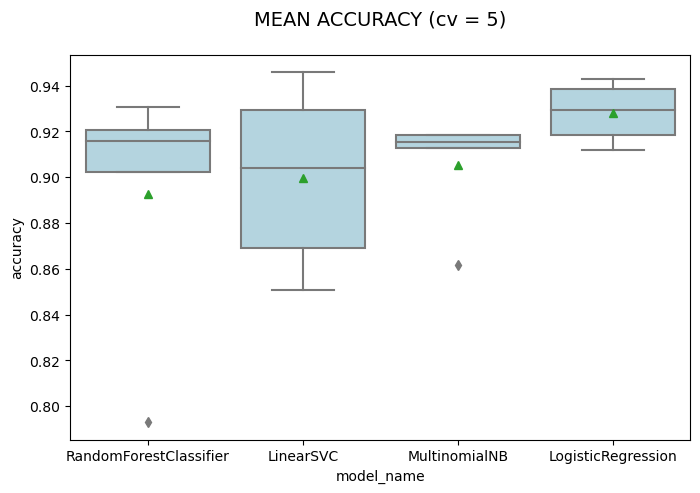

In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [61]:


X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               train_df.index, test_size=0.25, 
                                                               random_state=0)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [62]:


# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= train_df['product_category'].unique()))



				CLASSIFICATIION METRICS



ValueError: Number of classes, 14, does not match size of target_names, 16. Try specifying the labels parameter